# Webスクレイピングを利用した形態素分析による可視化
**コード構成**

+ 1, ライブラリのインポート
+ 2, サイトにアクセスし、WEBサイトから情報取得してCSVファイルに出力
+ 3, 歌詞データ（日本語の文章）の抽出
+ 4, 歌詞データ（日本語の文章）を形態素分析
+ 5, 描画

**1, まずはライブラリを一気にインポートします！**

In [1]:
# ライブラリのインストール
# [requests]：webサイトにアクセスして情報を取得できるライブラリ
# [BeautifulSoup]：HTMLの各要素の情報を取得できるライブラリ
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

# 「Janome」：日本を形態素分析できるライブラリ
# 「WodCloud」：頻出単語の頻度に応じて大きさを調整できるライブラリ
from janome.tokenizer import Tokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import matplotlib
from matplotlib.font_manager import FontProperties

# マスク画像を使って表現の幅を広げる
# ImageColorGeneratorとImageを追加でインポート
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import numpy as np

**2, この部分でWebサイトにアクセスし、WEBサイトから情報取得してCSVファイルに出力を行なっています。**

今回はurlにEXILEさんの歌詞ページのトップページを指定しています。urlのあるwebサイト情報をresponseに代入、さらにHTMLの情報のみをsoupに代入して、<td class=’side td1′>の情報全てをlinksに代入しています。　

In [2]:
#スクレイピングしたデータを入れるフォーマットを作成
list_df = pd.DataFrame(columns=['曲名','歌詞'])

 次にfor文使ってlinksに代入している全ての曲名のリンクをlinkに１つずつ代入して、

曲名をsong_name、歌詞の情報をsong_kashiに代入しています。

In [3]:
#歌詞ページのページ数（xページ）に合わせて、　xに＋１して（０,x+1）
for page in range(0,1): 
    base_url = 'https://www.uta-net.com'

    #歌詞一覧ページを取得
    #複数ページの場合（url = 'https://www.uta-net.com/artist/******/0/' + str(page) + '/'）
    url = 'https://www.uta-net.com/artist/289/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    links = soup.find_all('td', class_='side td1')
    
    #歌詞情報を取得
    for link in links:
        a = base_url + (link.a.get('href'))
        response = requests.get(a)
        soup = BeautifulSoup(response.text, 'lxml')
        song_name = soup.find('h2').text
        detail = soup.find('p', class_="detail").text
        
        song_kashi = soup.find('div', id="kashi_area")
        song_kashi = song_kashi.text
        song_kashi = song_kashi.replace('\n','')
        song_kashi = song_kashi.replace('この歌詞をマイ歌ネットに登録 >このアーティストをマイ歌ネットに登録 >','　')
        #サーバーに負荷を与えないため1秒待機
        time.sleep(1)
        #取得した歌詞を表に追加
        tmp_se = pd.DataFrame([[song_name], [song_kashi]], index=list_df.columns).T
        list_df = list_df.append(tmp_se)

#csv保存
list_df.to_csv('exile_list.csv', mode = 'w', encoding='utf-8')

### 形態素解析のライブラリを使って、exileの歌詞を単語に分けて、さらにwordcloudで頻出語句ほど多く表示させることで、歌詞を分析していきます。

この部分ではCSVのデータを読み込み、dfに代入します。歌詞や文章のCSVデータは分析で使うpythonファイルと同じディレクトリに保存して置いてください。

In [4]:
df = pd.read_csv('exile_list.csv')
tiamo =df.loc[101,'歌詞']

In [5]:
df.info

<bound method DataFrame.info of      Unnamed: 0               曲名  \
0             0           アガパンサス   
1             0           HEMERA   
2             0          Freedom   
3             0  DOWN TOWN TOKYO   
4             0     NEO UNIVERSE   
..          ...              ...   
191           0      RED PHOENIX   
192           0            浪漫の地球   
193           0         One Wish   
194           0       One Nation   
195           0         One love   

                                                    歌詞  
0    波のようにしなやかに踊る君と揺らめく火のように静かにたたずむ僕はその心を掴める言葉(セリフ)...  
1    呆れる程の　山積みの備忘録遠く聞こえた“もう捨てていいんだよ”いつの間にやら膨れ上がった防衛...  
2    You and I掌　重ねた日々がI don't know why時の中　声も聞こえない w...  
3    hey yo百花繚乱　スクランブルの交差点(ランウェイ)歌舞いて踊る U&IHey Let'...  
4    Fly to the future見逃すな目の前広がるNeo UniverseYeahYea...  
..                                                 ...  
191  Oh...RiseRising sun...to the worldYeah We star...  
192  会いたい気持ちは僕が会いたいだけじゃないもし君が笑って幸せを感じて元気になるなら今すぐ飛んで...  
193  いつでも僕らはこの空の上で手をつな

今回は「Ti Amo」の歌詞を分析するので、「Ti Amo」の歌詞のみをtiamoに代入します。この部分で歌詞の形態素解析をしています。歌詞を単語に分けた後、word_listという空のリストに’名詞’、’動詞’、’形容詞’、’形容動詞’のみ追加していきます。

In [6]:
t = Tokenizer()
tokens = t.tokenize(tiamo)
 
word_list=[]
for token in tokens:
    word = token.surface
    partOfSpeech = token.part_of_speech.split(',')[0]
    partOfSpeech2 = token.part_of_speech.split(',')[1]
     
    if partOfSpeech in['名詞', '動詞', '形容詞', '形容動詞']:
        if (partOfSpeech != "記号"):
            if (partOfSpeech2 != "非自立") and (partOfSpeech2 != "代名詞") and (partOfSpeech2 != "数"):
                word_list.append(word)
 
words=" ".join(word_list)
print(words)  

日曜日 夜 ベッド 広い 眠ら 想い 抱い 朝 待つ 帰る 場所 ある 好き なっ わかっ 初め 想い 愛 呼ん いい 胸 しめつけ 気持ち 名前 ください キス する 目 閉じ 未来 ( あした ) 見 抱きしめ られる ときめく 心 信じ 声 出さ 愛し 叫ぶ きまり 台詞 なぞる 遊び 恋 向い むかし 傷つけ 恋 人 愛 呼ぶ 罪 背負い 生き 覚悟 でき 部屋 出る 言っ 終止符 打た せ 最後 わがまま ひとり ラブソング 歌え 早く 会え 知り あえ ふたり 歩幅 合わせ られ 長く 会え 向き あえ ふたり 心 重ね ( Ti Amo ) キス する 目 閉じ 未来 ( あした ) 見 抱きしめ られる ときめく 心 信じ 声 出さ 愛し ...「 弱い 自分 告げ ずるい 人 時計 はずし 微笑ん 優しい 人 笑顔 くずさ 嘘 見抜き


In [7]:
font_path = './TakaoPGothic.ttf'  #DLしたパスを指定. /font以下でなくても良い
font_prop = FontProperties(fname=font_path)

In [8]:
stop_words = ['し','さ','れ','ない']  # 表示させない単語の設定
fpath = 'TakaoPGothic.ttf'  # 日本語フォント指定

https://github.com/byrongibson/fonts/tree/master/backup/truetype.original/takao-gothic

描画の設定を行います。stop_wordsでは描画させない単語を選定します。あまり意味を持たない単語や、頻出し過ぎている単語がに設定します。描画後にこの言葉はいらないなーと思った際に適宜追加します。さらに図の大きさ、背景の色の設定を行なっています。

In [9]:
wordcloud = WordCloud(
    font_path=fpath,
    width=900, height=600,   # default width=400, height=200
    background_color="white",   # default=”black”
    stopwords=set(stop_words),
    max_words=500,   # default=200
    min_font_size=4,   #default=4
    collocations = False   #default = True
    ).generate(words)

ここで描画、出力した内容を画像保存しています。

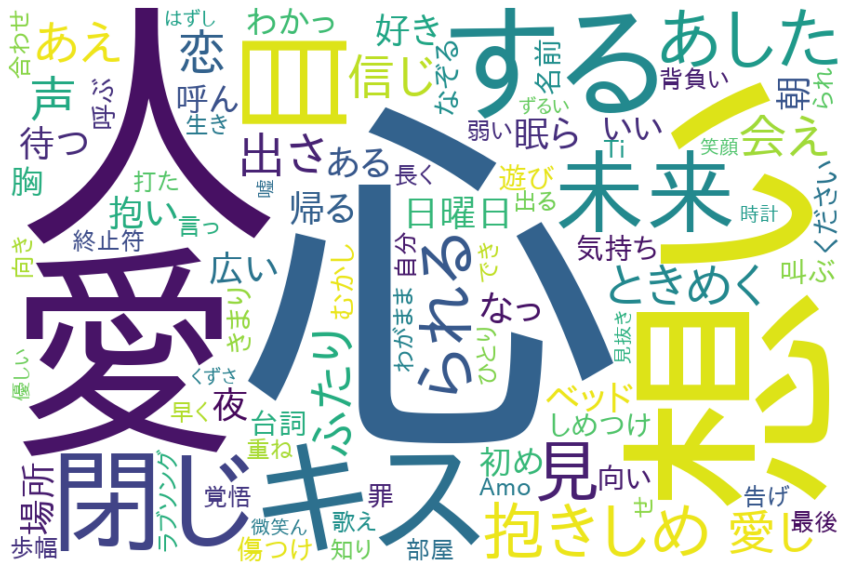

In [10]:
plt.figure(figsize=(15,12))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.savefig("tiamo.png")
plt.show()

# マスク画像を使って表現の幅を広げる

使用する画像はpythonのファイルと同じディレクトリに保存して下さい。画像は背景が白でないとうまくいきません。

In [11]:
img_color = np.array(Image.open('exile1.png'))

ここで画像の色を分析して、抽出します。

In [12]:
wordcloud = WordCloud(
    font_path=fpath,
    width=900, height=600,   # default width=400, height=200
    background_color="white",   # default=”black”
    stopwords=set(stop_words),
    max_words=500,   # default=200
    min_font_size=4,   #default=4
    # mask=img_color　抽出した画像の色を描画の際に活用する設定です。
    mask=img_color,
    collocations = False   #default = True
    ).generate(words)

image_colors = ImageColorGenerator(img_color)

mask=img_colorで抽出した画像の形を描画の際に活用する設定を行います。image_colors = ImageColorGenerator(img_color)で抽出した画像の色を描画の際に活用するために色の情報をimage_colorsに代入します。wordcloud.recolor(color_func=image_colors)で描画の色に画像の色を使う設定を行います。

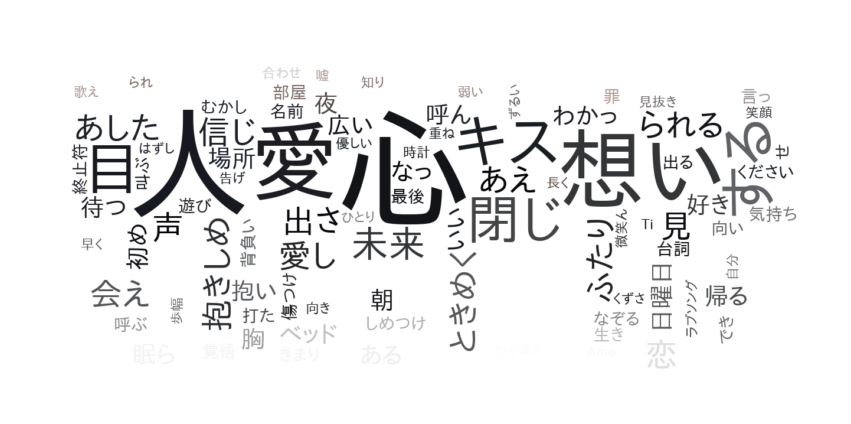

In [13]:
plt.figure(figsize=(15,12))
plt.imshow(wordcloud.recolor(color_func=image_colors),interpolation="bilinear")
plt.axis("off")
plt.savefig("tiamo_mask.png")
plt.show()